# Nenana Ice Classic Modeling
This notebook was used for modeling the NIC data.

In [1]:
# imports

import numpy as np
import pandas as pd

# plotting
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# import datetime

import warnings
warnings.filterwarnings("ignore")
import gc # garbage collection

In [2]:
from sklearn.preprocessing import RobustScaler, QuantileTransformer, Normalizer
from sklearn.preprocessing import PowerTransformer, KBinsDiscretizer, FunctionTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from category_encoders import WOEEncoder, OrdinalEncoder #TargetEncoder
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.model_selection import cross_val_score, TimeSeriesSplit, cross_validate, cross_val_predict
from sklearn.svm import SVC

# metrics
from sklearn import metrics # explained_variance_score, mean_absolute_error, mean_squared_error, r2_score
#from sklearn.utils import check_arrays # converts list-like objects to array (if needed)

In [3]:
def stringify(data):
    data = pd.DataFrame(data)
    for c in data.columns.tolist():
        data[c] = data[c].astype(str)
    return data

In [4]:
# read data
df = pd.read_csv('../data/cleaned_data.csv')

In [5]:
df.head()

,Unnamed: 0,Date,readingTime,weatherSummary,icon,sunriseTime,sunsetTime,moonPhase,precipIntensity,precipIntensityMax,...,temperatureMaxTime,apparentTemperatureMin,apparentTemperatureMinTime,apparentTemperatureMax,apparentTemperatureMaxTime,precipType,precipAccumulation,winningTime,daylightHours,iceThickness
0,0,2009-04-01,1238572800,Partly cloudy throughout the day.,partly-cloudy-day,1238598720,1238647800,0.24,0.0,0.0,...,1238623320,-0.27,1238579940,17.69,1238608560,none,0.0,0,0.568056,45.0
1,1,2009-04-02,1238659200,Partly cloudy throughout the day.,partly-cloudy-day,1238684940,1238734380,0.27,0.0,0.0,...,1238726100,-19.98,1238684760,20.02,1238735040,none,0.0,0,0.572222,45.0
2,2,2009-04-03,1238745600,Clear throughout the day.,clear-day,1238771100,1238820960,0.31,0.0,0.0,...,1238804700,-5.11,1238773740,29.20,1238798700,none,0.0,0,0.577083,45.0
3,3,2009-04-04,1238832000,Clear throughout the day.,clear-day,1238857260,1238907540,0.34,0.0,0.0,...,1238896800,-7.95,1238859660,20.35,1238896920,none,0.0,0,0.581944,45.0
4,4,2009-04-05,1238918400,Clear throughout the day.,clear-day,1238943480,1238994120,0.38,0.0,0.0,...,1238985180,-7.83,1238929200,28.09,1238989980,none,0.0,0,0.586111,45.0


In [6]:
df.drop(columns = 'Unnamed: 0', inplace = True)

## Feature Engineering

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 669 entries, 0 to 668
Data columns (total 41 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Date                         669 non-null    object 
 1   readingTime                  669 non-null    int64  
 2   weatherSummary               669 non-null    object 
 3   icon                         669 non-null    object 
 4   sunriseTime                  669 non-null    int64  
 5   sunsetTime                   669 non-null    int64  
 6   moonPhase                    669 non-null    float64
 7   precipIntensity              669 non-null    float64
 8   precipIntensityMax           669 non-null    float64
 9   precipProbability            669 non-null    float64
 10  temperatureHigh              669 non-null    float64
 11  temperatureHighTime          669 non-null    int64  
 12  temperatureLow               669 non-null    float64
 13  temperatureLowTime  

In [8]:
df['Date'] = pd.to_datetime(df['Date'])

In [9]:
df['winningTime'] = pd.to_datetime(df['winningTime'], errors = 'ignore')

In [10]:
# create column for ordinal day of year
df['dayOfYear'] = df['Date'].dt.dayofyear

In [11]:
# create binary 'winningDate' column
df['winningDate'] = 0
idx = df.loc[df['winningTime'] != '0'].index
df['winningDate'].loc[idx] = 1

In [12]:
# df.plot(x = 'Date', y = 'iceThickness', kind = 'scatter', figsize = (10, 6))
# df.plot(x = 'Date', y = 'temperatureMin', kind = 'scatter', figsize = (10, 6))
# plt.show();

Let's continue by dropping the columns that I don't think will help with this prediction task.

Reasoning behind dropping these columns:
* Most time features dropped were because they only captured a single, specific event (the time the daytime high temperature was recorded, for example) _thinking about this, I may go back and get hourly data; something like length of time that the temperature was high or low for a day might have an impact?_
* "apparentTemperature" features were dropped because they're a representation of what conditions feel like, not what they actually are.
* Sunrise and sunset times were dropped because that information was captured in 'daylightHours'
* "weatherSummary" and "icon" features were dropped because they're text summaries of information captured by other features.
* "precipProbability" was dropped because this is past data and the presence/amount of precipitation is known.
* "precipIntensityMax" was dropped because the precipitation rate is already captured by "precipIntensity" and I don't think knowing the maximum precipitation rate adds anything.
* "visibility" was dropped because atmospheric conditions are already captured by other features ("cloudCover," "uvIndex," "precipIntensity" to name some)
* "temperatureHigh" and "temperatureLow" were dropped because the first is the daytime high and the second is the nighttime low; the 24 hour maximum and minimum are captured by "temperatureMax" and "temperatureMin" respectively

In [14]:
df.drop(columns = ['readingTime', 'weatherSummary', 'icon', 'sunriseTime', 'sunsetTime', 'precipProbability',
                   'apparentTemperatureHigh', 'apparentTemperatureHighTime', 'apparentTemperatureLow',
                   'apparentTemperatureLowTime', 'uvIndexTime', 'apparentTemperatureMin',
                   'apparentTemperatureMinTime', 'apparentTemperatureMax', 'apparentTemperatureMaxTime',
                   'visibility', 'precipIntensityMax', 'dewPoint',
                   'temperatureHigh', 'temperatureHighTime', 'temperatureLow', 'temperatureLowTime',
                   'temperatureMinTime', 'temperatureMaxTime'],
        inplace = True)

---
These features worked the best (so far) with logreg; drop all but these? experiment further first?

used_cols = ['numColdDays', 'iceThickness', 'dayOfYear', 'uvIndex', 'precipIntensity', 'humidity']

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 669 entries, 0 to 668
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Date                669 non-null    datetime64[ns]
 1   moonPhase           669 non-null    float64       
 2   precipIntensity     669 non-null    float64       
 3   humidity            669 non-null    float64       
 4   atmoPressure        669 non-null    float64       
 5   windSpeed           669 non-null    float64       
 6   windGust            669 non-null    float64       
 7   windBearing         669 non-null    int64         
 8   cloudCover          669 non-null    float64       
 9   uvIndex             669 non-null    float64       
 10  temperatureMin      669 non-null    float64       
 11  temperatureMax      669 non-null    float64       
 12  precipType          669 non-null    object        
 13  precipAccumulation  669 non-null    float64       

In [16]:
df['past'] = (df['Date'] < '2017-01-01').astype(np.int)

In [17]:
df['future'] = 1 - df['past']

In [18]:
df.head().append(df.tail())

,Date,moonPhase,precipIntensity,humidity,atmoPressure,windSpeed,windGust,windBearing,cloudCover,uvIndex,...,temperatureMax,precipType,precipAccumulation,winningTime,daylightHours,iceThickness,dayOfYear,winningDate,past,future
0,2009-04-01,0.24,0.0000,0.64,1014.8,4.44,24.30,252,0.62,2.0,...,22.56,none,0.0,0,0.568056,45.0,91,0,1,0
1,2009-04-02,0.27,0.0000,0.57,1019.5,2.97,11.84,90,0.39,2.0,...,24.72,none,0.0,0,0.572222,45.0,92,0,1,0
2,2009-04-03,0.31,0.0000,0.51,1015.2,2.58,13.08,324,0.21,3.0,...,31.73,none,0.0,0,0.577083,45.0,93,0,1,0
3,2009-04-04,0.34,0.0000,0.58,1022.7,4.13,16.16,314,0.30,3.0,...,25.51,none,0.0,0,0.581944,45.0,94,0,1,0
4,2009-04-05,0.38,0.0000,0.58,1018.9,2.51,13.69,66,0.00,3.0,...,31.85,none,0.0,0,0.586111,45.0,95,0,1,0
664,2019-05-27,0.80,0.0003,0.42,1006.8,3.90,33.37,226,0.29,4.0,...,67.58,rain,0.0,0,0.827778,25.0,147,0,0,1
665,2019-05-28,0.83,0.0008,0.55,1013.8,2.27,6.06,352,0.62,4.0,...,66.95,rain,0.0,0,0.832639,25.0,148,0,0,1
666,2019-05-29,0.86,0.0001,0.51,1014.4,2.54,9.64,108,0.44,4.0,...,70.30,rain,0.0,0,0.836806,25.0,149,0,0,1
667,2019-05-30,0.89,0.0001,0.40,1011.0,2.75,11.37,99,0.41,5.0,...,74.71,rain,0.0,0,0.840972,25.0,150,0,0,1
668,2019-05-31,0.92,0.0067,0.68,1005.3,2.29,8.64,343,0.91,3.0,...,65.79,rain,0.0,0,0.845139,25.0,151,0,0,1


In [19]:
df.loc[df['winningDate'] == 1]

,Date,moonPhase,precipIntensity,humidity,atmoPressure,windSpeed,windGust,windBearing,cloudCover,uvIndex,...,temperatureMax,precipType,precipAccumulation,winningTime,daylightHours,iceThickness,dayOfYear,winningDate,past,future
30,2009-05-01,0.26,0.0000,0.30,1019.5,1.94,9.18,305,0.00,4.0,...,74.64,none,0.0,8:41 PM,0.709028,42.7,121,1,1,0
89,2010-04-29,0.56,0.0000,0.42,1004.0,2.36,23.01,176,0.58,4.0,...,63.59,none,0.0,9:06 AM,0.698611,40.9,119,1,1,0
155,2011-05-04,0.06,0.0000,0.45,1009.9,2.70,0.00,284,0.40,4.0,...,51.60,none,0.0,4:24 PM,0.720833,39.0,124,1,1,0
205,2012-04-23,0.09,0.0000,0.56,1010.7,3.82,17.21,76,0.13,4.0,...,57.97,none,0.0,7:39 PM,0.672222,28.7,114,1,1,0
293,2013-05-20,0.35,0.0000,0.33,1034.6,2.74,12.43,144,0.00,5.0,...,54.55,none,0.0,2:41 PM,0.799306,40.0,140,1,1,0
329,2014-04-25,0.89,0.0000,0.47,999.1,4.51,22.92,142,0.33,4.0,...,54.33,none,0.0,3:48 PM,0.679861,36.5,115,1,1,0
389,2015-04-24,0.23,0.0000,0.27,1006.1,3.12,11.17,109,0.00,4.0,...,56.60,none,0.0,2:25 PM,0.673611,36.5,114,1,1,0
449,2016-04-23,0.56,0.0000,0.47,1004.0,3.44,9.71,321,0.41,4.0,...,59.60,none,0.0,3:39 PM,0.672222,32.3,114,1,1,0
518,2017-05-01,0.22,0.0000,0.44,1005.8,3.88,11.00,107,0.12,4.0,...,56.54,none,0.0,12:00 PM,0.709028,29.7,121,1,0,1
579,2018-05-01,0.57,0.0005,0.70,1007.4,5.14,11.89,226,0.91,3.0,...,43.57,rain,0.0,1:18 PM,0.707639,25.0,121,1,0,1


In [20]:
df['precipType'].value_counts()

none    541
rain     89
snow     39
Name: precipType, dtype: int64

In [21]:
# encode precipType
df = df.merge(pd.get_dummies(df['precipType'], prefix = 'precip', drop_first = True, sparse = True),
         how = 'left', left_index = True, right_index = True)

Create column for daily average temperature

In [22]:
df['temperatureAvg'] = (df['temperatureMin'] + df['temperatureMax']) / 2

Create columns for number of "hot days" and "cold days" in a given year.

I defined a "hot day" as a day where: day_average_temp > median(year_avg_temp) + std_dev(year_avg_temp)

A "cold day" is a day where: day_average_temp < median(year_avg_temp) - std_dev(year_avg_temp)

In [23]:
year_list = sorted(list(set(df['Date'].dt.year)))

In [24]:
year_list

[2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]

In [25]:
hot_count = []
cold_count = []
for year in year_list:
    hot_temp_count = 0
    cold_temp_count = 0
    temp_df = df.loc[df['Date'].dt.year == year]
    hot_threshold = temp_df['temperatureAvg'].median() + temp_df['temperatureAvg'].std()
    cold_threshold = temp_df['temperatureAvg'].median() - temp_df['temperatureAvg'].std()
    for idx in temp_df.index:
        current_temp = temp_df['temperatureAvg'].loc[idx]
        if current_temp >= hot_threshold:
            hot_temp_count += 1
        elif current_temp <= cold_threshold:
            cold_temp_count += 1
        else:
            pass
        hot_count.append(hot_temp_count)
        cold_count.append(cold_temp_count)

In [26]:
df['numHotDays'] = hot_count
df['numColdDays'] = cold_count

## Modeling

In [27]:
df_past = df.loc[df['past'] == 1]
df_past.drop(columns = ['past', 'future'], inplace = True)

In [28]:
df_past.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 488 entries, 0 to 487
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype           
---  ------              --------------  -----           
 0   Date                488 non-null    datetime64[ns]  
 1   moonPhase           488 non-null    float64         
 2   precipIntensity     488 non-null    float64         
 3   humidity            488 non-null    float64         
 4   atmoPressure        488 non-null    float64         
 5   windSpeed           488 non-null    float64         
 6   windGust            488 non-null    float64         
 7   windBearing         488 non-null    int64           
 8   cloudCover          488 non-null    float64         
 9   uvIndex             488 non-null    float64         
 10  temperatureMin      488 non-null    float64         
 11  temperatureMax      488 non-null    float64         
 12  precipType          488 non-null    object          
 13  precipAccumulation  

In [29]:
df_future = df.loc[df['future'] == 1]
df_future.drop(columns = ['past', 'future'], inplace = True)

In [30]:
df_future.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 181 entries, 488 to 668
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype           
---  ------              --------------  -----           
 0   Date                181 non-null    datetime64[ns]  
 1   moonPhase           181 non-null    float64         
 2   precipIntensity     181 non-null    float64         
 3   humidity            181 non-null    float64         
 4   atmoPressure        181 non-null    float64         
 5   windSpeed           181 non-null    float64         
 6   windGust            181 non-null    float64         
 7   windBearing         181 non-null    int64           
 8   cloudCover          181 non-null    float64         
 9   uvIndex             181 non-null    float64         
 10  temperatureMin      181 non-null    float64         
 11  temperatureMax      181 non-null    float64         
 12  precipType          181 non-null    object          
 13  precipAccumulation

In [31]:
df.drop(columns = ['past', 'future'], inplace = True)
gc.collect()

22

In [32]:
exclude = ['winningTime', 'winningDate', 'precipType', 'Date']

In [33]:
used_cols = [c for c in df_past.columns if c not in exclude]
target = 'winningDate'

scaler = RobustScaler()
encoder = WOEEncoder()
binner = KBinsDiscretizer(n_bins=7, encode='ordinal')
objectify = FunctionTransformer(func=stringify, check_inverse=False, validate=False)
clf_lr = LogisticRegressionCV(class_weight='balanced',
                              cv = TimeSeriesSplit(),
                              solver = 'liblinear',
                              n_jobs=-1,
                              random_state=42)
pipe = make_pipeline(scaler, binner, objectify, encoder, clf_lr)

X, y = df_past[used_cols].values, df_past[target].values
scores = cross_val_score(pipe, X, y, cv = 5, scoring='roc_auc')
scores.mean(), scores.std()

(0.5854166666666667, 0.2776896561611341)

In [34]:
pipe.fit(X, y)

Pipeline(memory=None,
         steps=[('robustscaler',
                 RobustScaler(copy=True, quantile_range=(25.0, 75.0),
                              with_centering=True, with_scaling=True)),
                ('kbinsdiscretizer',
                 KBinsDiscretizer(encode='ordinal', n_bins=7,
                                  strategy='quantile')),
                ('functiontransformer',
                 FunctionTransformer(accept_sparse=False, check_inverse=False,
                                     func=<function stringify at 0x1a2044bb70>,
                                     inv_kw_ar...
                            return_df=True, sigma=0.05, verbose=0)),
                ('logisticregressioncv',
                 LogisticRegressionCV(Cs=10, class_weight='balanced',
                                      cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
                                      dual=False, fit_intercept=True,
                                      intercept_scaling=1

In [35]:
for n, v in enumerate(clf_lr.coef_[0]):
    print(n, v)

0 26.199328711836934
1 9.858285013785201
2 13.613881201355566
3 6.57564915442644
4 22.030467427111613
5 15.173697604176231
6 15.77681131383628
7 6.414360685053835
8 3.0069217039539664
9 -1.192293605686577
10 2.0961043133952115
11 9.858285013785201
12 -2.974494427673559
13 4.87063559426244
14 16.579438489538134
15 9.858285013785201
16 9.858285013785201
17 8.82523206249823
18 -4.543650554810206
19 27.491275438299443


In [36]:
for n, v in enumerate(used_cols):
    print(n, v)

0 moonPhase
1 precipIntensity
2 humidity
3 atmoPressure
4 windSpeed
5 windGust
6 windBearing
7 cloudCover
8 uvIndex
9 temperatureMin
10 temperatureMax
11 precipAccumulation
12 daylightHours
13 iceThickness
14 dayOfYear
15 precip_rain
16 precip_snow
17 temperatureAvg
18 numHotDays
19 numColdDays


In [37]:
df.corr()

,moonPhase,precipIntensity,humidity,atmoPressure,windSpeed,windGust,windBearing,cloudCover,uvIndex,temperatureMin,...,precipAccumulation,daylightHours,iceThickness,dayOfYear,winningDate,precip_rain,precip_snow,temperatureAvg,numHotDays,numColdDays
moonPhase,1.000000,0.067106,-0.028577,0.017543,0.026723,-0.007204,-0.041372,-0.018501,0.010574,0.049027,...,0.048698,-0.008459,0.004085,-0.007913,-0.058154,0.007175,0.059015,0.034980,0.028956,-0.016791
precipIntensity,0.067106,1.000000,0.355641,-0.106531,0.007225,-0.016719,0.063413,0.353154,-0.115880,0.093117,...,0.443183,0.050106,-0.064041,0.050959,-0.024972,0.402450,0.249285,0.015961,0.035184,0.030649
humidity,-0.028577,0.355641,1.000000,-0.102217,-0.132118,-0.180443,0.299888,0.638935,-0.482652,-0.155253,...,0.279781,-0.217878,-0.095431,-0.215486,-0.039496,0.305359,0.416743,-0.278128,-0.029781,-0.165297
atmoPressure,0.017543,-0.106531,-0.102217,1.000000,-0.110722,-0.102845,0.083222,-0.110994,0.121692,-0.121386,...,-0.107108,0.113788,0.211448,0.110838,-0.017765,-0.084107,-0.093904,-0.065794,0.037023,0.091020
windSpeed,0.026723,0.007225,-0.132118,-0.110722,1.000000,0.633892,-0.149758,0.004043,-0.136720,-0.024097,...,0.046211,-0.166874,-0.011979,-0.167927,-0.005084,-0.030106,0.049521,-0.149976,-0.161260,-0.126445
windGust,-0.007204,-0.016719,-0.180443,-0.102845,0.633892,1.000000,-0.223915,-0.077624,0.013681,0.059471,...,-0.006478,-0.020044,0.104407,-0.019935,-0.049344,-0.045023,-0.052261,0.018259,-0.027780,-0.148981
windBearing,-0.041372,0.063413,0.299888,0.083222,-0.149758,-0.223915,1.000000,0.269468,-0.100029,-0.076477,...,0.071247,-0.041149,0.098382,-0.040889,-0.006145,-0.009074,0.108762,-0.154042,0.014516,-0.063521
cloudCover,-0.018501,0.353154,0.638935,-0.110994,0.004043,-0.077624,0.269468,1.000000,-0.310723,0.142892,...,0.221584,0.084043,-0.107611,0.084154,-0.012571,0.353735,0.336081,-0.050116,0.009316,0.043780
uvIndex,0.010574,-0.115880,-0.482652,0.121692,-0.136720,0.013681,-0.100029,-0.310723,1.000000,0.567022,...,-0.154324,0.766536,-0.006174,0.766293,0.008041,-0.043530,-0.299957,0.663231,0.460936,0.500583
temperatureMin,0.049027,0.093117,-0.155253,-0.121386,-0.024097,0.059471,-0.076477,0.142892,0.567022,1.000000,...,-0.130068,0.778425,-0.299926,0.780746,0.019164,0.291592,-0.152690,0.955055,0.551016,0.425169


#### LogReg Performance Tracking
* col_set_1 = used_cols = ['temperatureMin', 'daylightHours', 'iceThickness', 'uvIndex']
* col_set_2 = used_cols = ['temperatureMin', 'daylightHours', 'uvIndex']
* col_set_3 = used_cols = ['moonPhase', 'precipIntensity', 'dewPoint', 'humidity', 'atmoPressure', 'cloudCover', 'uvIndex', 'temperatureMin', 'temperatureMax', 'precipAccumulation', 'daylightHours', 'iceThickness', 'dayOfYear']
* col_set_4 = used_cols = ['moonPhase', 'precipIntensity', 'dewPoint', 'humidity', 'atmoPressure', 'cloudCover', 'uvIndex', 'temperatureMin', 'temperatureMax', 'precipAccumulation', 'daylightHours', 'iceThickness', 'dayOfYear', 'temperatureAvg']

##### This is the code for col_set_3 and col_set_4: _used_cols = [c for c in df_past.columns if c not in exclude]_
* param_set_1 = [class_weight = 'balanced', solver = 'lbfgs', cv = 5]
* param_set_2 = [class_weight = 'balanced', solver = 'liblinear', cv = TimeSeriesSplit]

|Features|Parameters|Metric|Mean Score|Std Dev|
|--------|----------|------|----------|-------|
|col_set_1|param_set_1|F1_weighted|0.8986533623418216|0.04454869713051795|
|col_set_2|param_set_1|F1_weighted|0.9060633297947135|0.03855568639641947|
|col_set_3|param_set_1|F1_weighted|0.9514210817068249|0.014427740803603184|

##### After Switching To TimeSeriesSplit
|Features|Parameters|Metric|Mean Score|Std Dev|
|--------|----------|------|----------|-------|
|col_set_3|param_set_1|F1_weighted|0.9320965992741564|0.05195770999527227|
|col_set_4|param_set_2|F1_weighted|0.9503848122767732|0.013624547905268819|

#### Trying to figure out which metric to use
I'm leaning toward roc_auc, since it's a function of true positives vs true negatives. I'm feeling that's a better measure of accuracy than F1 score.

In [38]:
temp_exclude = ['winningTime', 'winningDate', 'precipType', 'Date',
                'temperatureMin', 'temperatureMax', 'moonPhase', 'atmoPressure', 'precipIntensityMax']
# used_cols = [c for c in df_past.columns if c not in temp_exclude]
used_cols = ['numColdDays', 'iceThickness', 'dayOfYear', 'uvIndex', 'precipIntensity', 'humidity']
target = 'winningDate'

scaler = RobustScaler()
encoder = WOEEncoder()
binner = KBinsDiscretizer(n_bins=7, encode='ordinal')
objectify = FunctionTransformer(func=stringify, check_inverse=False, validate=False)
clf_lr = LogisticRegressionCV(class_weight='balanced',
                              solver = 'liblinear',
                              cv = TimeSeriesSplit(),
                              n_jobs=-1,
                              random_state=42)
pipe = make_pipeline(scaler, binner, objectify, encoder, clf_lr)

X, y = df_past[used_cols].values, df_past[target].values
scores = cross_validate(pipe, X, y, cv = 5, scoring=['f1_weighted',
                                                     'precision_weighted',
                                                     'recall_weighted',
                                                     'roc_auc'])
# scores.mean(), scores.std()
print('f1_weighted:', scores['test_f1_weighted'].mean(), '+/-', scores['test_f1_weighted'].std())
print('precision_weighted:', scores['test_precision_weighted'].mean(),
      '+/-', scores['test_precision_weighted'].std())
print('recall_weighted:', scores['test_recall_weighted'].mean(), '+/-', scores['test_recall_weighted'].std())
print('roc_auc:', scores['test_roc_auc'].mean(), '+/-', scores['test_roc_auc'].std())

# f1_weighted: 0.9547853676767855 +/- 0.010212099074422252
# precision_weighted: 0.9694095112626832 +/- 0.01323815584038885
# recall_weighted: 0.9425415527035558 +/- 0.024098949420271486
# roc_auc: 0.5916666666666666 +/- 0.29989509161075345

f1_weighted: 0.90199871047501 +/- 0.04386464032272759
precision_weighted: 0.9733398734793972 +/- 0.014559333389943994
recall_weighted: 0.8500736377025037 +/- 0.08272292652734486
roc_auc: 0.8317708333333333 +/- 0.09339632361013414


used_cols = ['numColdDays', 'iceThickness', 'dayOfYear', 'uvIndex', 'precipIntensity', 'humidity']

roc_auc: 0.8317708333333333 +/- 0.09339632361013414

#### Metrics defined
* F1 = harmonic mean of precision and recall (2 * (precision * recall / precision + recall))
* precision = correct_pos_preds / total_pos_preds (percent correct of all positive predictions)
* recall = correct_pos_preds / total_actual_positives (True Positive Rate)
* roc_auc = https://en.wikipedia.org/wiki/Receiver_operating_characteristic (TPR vs TNR at a threshold)

In [39]:
used_cols

['numColdDays',
 'iceThickness',
 'dayOfYear',
 'uvIndex',
 'precipIntensity',
 'humidity']

In [40]:
pipe.fit(X, y)
X_test = df_future[used_cols]
y_test = df_future[target]
y_pred = pipe.predict(X_test)

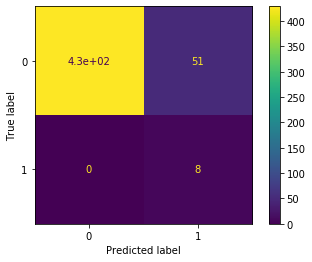

In [41]:
metrics.plot_confusion_matrix(pipe, X, y);

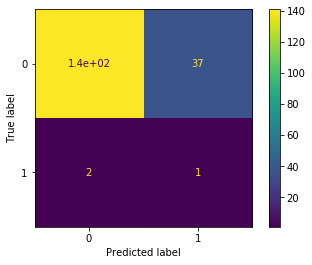

In [42]:
metrics.plot_confusion_matrix(pipe, X_test, y_test);

In [43]:
y_pred = pipe.predict_proba(X_test)[:,1]
y_pred[:5]

array([3.71672172e-04, 3.71672172e-04, 1.15879536e-06, 1.02546276e-03,
       1.76451506e-04])

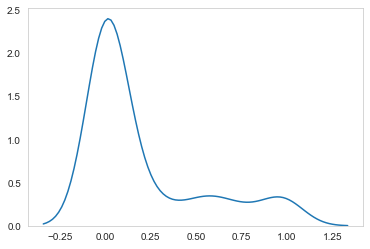

In [44]:
sns.set_style("whitegrid", {'axes.grid' : False})

sns.kdeplot(y_pred);

In [45]:
metrics.confusion_matrix(y_test, y_pred > 0.01)

array([[79, 99],
       [ 2,  1]])

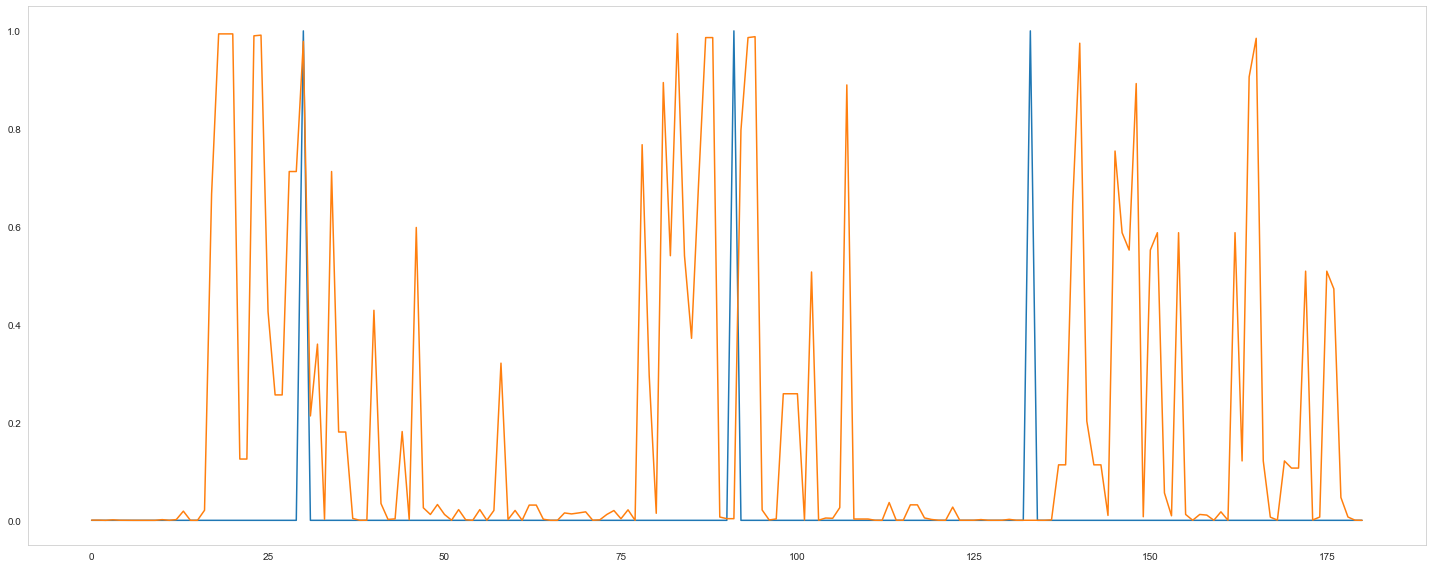

In [46]:
plt.figure(figsize=(20,8))
plt.plot(y_test.values)
plt.plot(y_pred)
plt.tight_layout()
plt.show()

In [47]:
# used_cols = [c for c in df_past.columns if c not in exclude]
used_cols = ['numColdDays', 'iceThickness', 'dayOfYear', 'uvIndex', 'precipIntensity', 'humidity']
target = 'winningDate'

scaler = RobustScaler()
encoder = WOEEncoder()
binner = KBinsDiscretizer(n_bins=7, encode='ordinal')
objectify = FunctionTransformer(func=stringify, check_inverse=False, validate=False)
clf_svc = SVC(C = 1000,
              kernel = 'rbf',
              gamma = 'auto',
              class_weight='balanced',
              random_state=42, probability=True)
pipe = make_pipeline(scaler, binner, objectify, encoder, clf_svc)

X, y = df_past[used_cols].values, df_past[target].values
scores = cross_val_score(pipe, X, y, cv=TimeSeriesSplit(), scoring='roc_auc')
scores.mean(), scores.std()

(0.7432753164556962, 0.15958442986070323)

In [48]:
used_cols

['numColdDays',
 'iceThickness',
 'dayOfYear',
 'uvIndex',
 'precipIntensity',
 'humidity']

#### SVM Performance Tracking
* col_set_1 = used_cols = ['temperatureMin', 'daylightHours', 'iceThickness', 'uvIndex']
* col_set_2 = used_cols = ['temperatureMin', 'daylightHours', 'uvIndex']
* col_set_3 = used_cols = ['moonPhase', 'precipIntensity', 'dewPoint', 'humidity', 'atmoPressure', 'cloudCover', 'uvIndex', 'temperatureMin', 'temperatureMax', 'precipAccumulation', 'daylightHours', 'iceThickness', 'dayOfYear']
* col_set_4 = used_cols = ['moonPhase', 'precipIntensity', 'dewPoint', 'humidity', 'atmoPressure', 'cloudCover', 'uvIndex', 'temperatureMin', 'temperatureMax', 'precipAccumulation', 'daylightHours', 'iceThickness', 'dayOfYear', 'temperatureAvg']

##### This is the code for col_set_3 and col_set_4: _used_cols = [c for c in df_past.columns if c not in exclude]_
* param_set_1 = [kernel = rbf, gamma = auto, C = 1000]
* param_set_2 = ...

|Features|Parameters|Metric|Mean Score|Std Dev|
|--------|----------|------|----------|-------|
|col_set_1|param_set_1|F1_weighted|0.9334011865162797|0.0210241113243519|
|col_set_2|param_set_1|F1_weighted|0.9019879153799234|0.02010337751295974|
|col_set_3|param_set_1|F1_weighted|0.9645615053025294|0.01165471341202916|

##### After Switching To TimeSeriesSplit
|Features|Parameters|Metric|Mean Score|Std Dev|
|--------|----------|------|----------|-------|
|col_set_3|param_set_1|F1_weighted|0.9608526326579732|0.020880533068704937|
|col_set_4|param_set_1|F1_weighted|0.9624961000779726|0.014817124058965039|

#### Trying to figure out which metric to use
I'm leaning toward roc_auc, since it's a function of true positives vs true negatives. I'm feeling that's a better measure of accuracy than F1 score.

In [49]:
temp_exclude = ['winningTime', 'winningDate', 'precipType', 'Date', 'temperatureMin', 'temperatureMax']
used_cols = [c for c in df_past.columns if c not in temp_exclude]
target = 'winningDate'

scaler = RobustScaler()
encoder = WOEEncoder()
binner = KBinsDiscretizer(n_bins=7, encode='ordinal')
objectify = FunctionTransformer(func=stringify, check_inverse=False, validate=False)
clf_svc = SVC(C = 1000,
              kernel = 'rbf',
              gamma = 'auto',
              class_weight='balanced',
              random_state=42, probability=True)
pipe = make_pipeline(scaler, binner, objectify, encoder, clf_svc)

X, y = df_past[used_cols].values, df_past[target].values
scores = cross_validate(pipe, X, y, cv = TimeSeriesSplit(), scoring=['f1_weighted',
                                                                     'precision_weighted',
                                                                     'recall_weighted',
                                                                     'roc_auc'])

print('f1_weighted:', scores['test_f1_weighted'].mean(), '+/-', scores['test_f1_weighted'].std())
print('precision_weighted:', scores['test_precision_weighted'].mean(),
      '+/-', scores['test_precision_weighted'].std())
print('recall_weighted:', scores['test_recall_weighted'].mean(), '+/-', scores['test_recall_weighted'].std())
print('roc_auc:', scores['test_roc_auc'].mean(), '+/-', scores['test_roc_auc'].std())

f1_weighted: 0.9665462273221366 +/- 0.012945924527359395
precision_weighted: 0.9655467715929055 +/- 0.01181899291974594
recall_weighted: 0.9679012345679011 +/- 0.022897823445668385
roc_auc: 0.758006329113924 +/- 0.09928187106157367


In [50]:
used_cols

['moonPhase',
 'precipIntensity',
 'humidity',
 'atmoPressure',
 'windSpeed',
 'windGust',
 'windBearing',
 'cloudCover',
 'uvIndex',
 'precipAccumulation',
 'daylightHours',
 'iceThickness',
 'dayOfYear',
 'precip_rain',
 'precip_snow',
 'temperatureAvg',
 'numHotDays',
 'numColdDays']

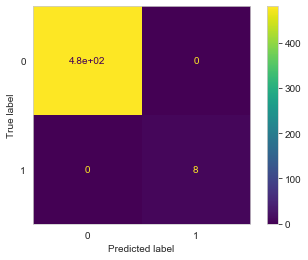

In [51]:
pipe.fit(X, y)
metrics.plot_confusion_matrix(pipe, X, y);

In [52]:
X_test = df_future[used_cols]
y_test = df_future[target]
y_pred = pipe.predict(X_test)

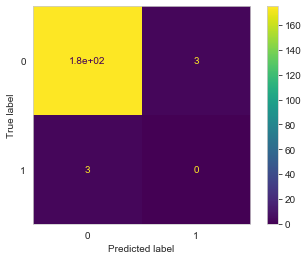

In [53]:
metrics.plot_confusion_matrix(pipe, X_test, y_test)

In [54]:
y_pred = pipe.predict_proba(X_test)[:,1]
y_pred[:5]

array([0.005075  , 0.00281039, 0.00120475, 0.0019929 , 0.00068575])

In [55]:
metrics.confusion_matrix(y_test, y_pred > 0.01)

array([[117,  61],
       [  1,   2]])

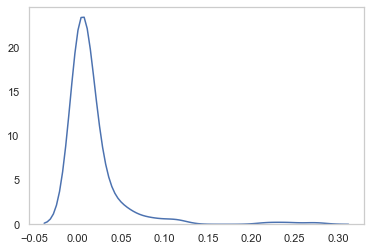

In [56]:
import seaborn as sns; sns.set()
sns.set_style("whitegrid", {'axes.grid' : False})

sns.kdeplot(y_pred);

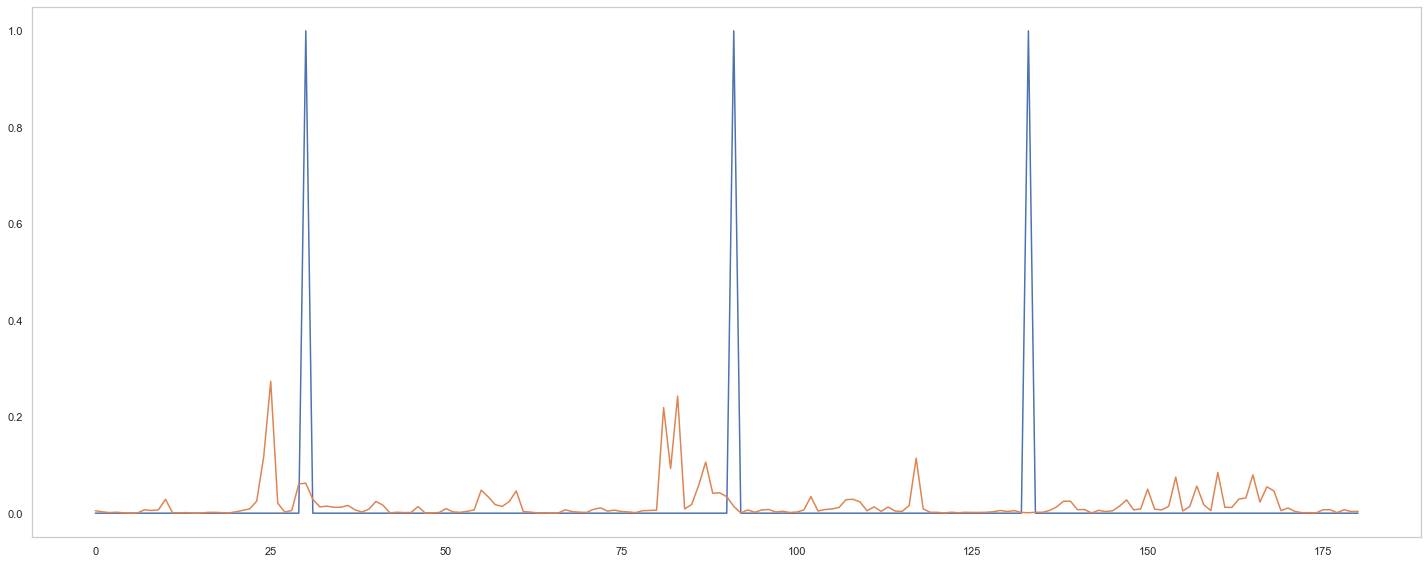

In [57]:
# plot of target vs predicted probability (multiplied by 10 so it was easier to see)
plt.figure(figsize=(20,8))
plt.plot(y_test.values)
plt.plot(y_pred)
plt.tight_layout()
plt.show()

_notes - add feature for day-of-year (to make the models time-aware)[x]; try hidden Markov model; look at survival analysis/time-to-event analysis; look for outliers in training data, if removed, does model performance improve?; is there any way to identify mechanical failure of ice vs mush-out?; more time-series-like features, for instance number of "hot" days vs number of "cold" days[x]; consider under- or over-sampling_

survival analysis: https://lifelines.readthedocs.io/en/latest/

Kaggle competition modeling time-to-event: https://www.kaggle.com/c/LANL-Earthquake-Prediction/discussion/94484

### Survival Analysis Application
Looked at from survival analysis point-of-view:

Each daily observation could be viewed like this:
* "birth": start of day with ice intact
* "death": end of day with ice intact
* Censored: ice breaks before end of day
  * there will be 11 censored observations here

Another way to look at it:
* "birth": start of day with ice intact
* "death": ice breaks
* Censored: end of day with ice intact
  * there will be ~660 censored observations here

look at it on a yearly basis instead of daily basis:
* "birth": start of observed period with ice intact
* "death": end of observed period with ice intact
* Censored: ice breaks before end of observed period
  * there will be 0 observations here, so I don't think this one is valid

OR
* "birth": start of observed period
* "death": ice breaks
* Censored: observed period ends with ice intact
  * there will be 0 censored observations here
  * I think this is the most promising
    * Y is % survival
    * X is day of year

In [126]:
df_survival = pd.read_csv('../data/ice_classic_winning_times.csv')

In [127]:
df_survival.head()

,Date,Time
0,1917-04-30,11:30 AM
1,1918-05-11,9:33 AM
2,1919-05-03,2:33 PM
3,1920-05-11,10:46 AM
4,1921-05-11,6:42 AM


In [128]:
df_survival.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103 entries, 0 to 102
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    103 non-null    object
 1   Time    103 non-null    object
dtypes: object(2)
memory usage: 1.7+ KB


In [129]:
df_survival['Date'] = pd.to_datetime(df_survival['Date'])
df_survival['Time'] = pd.to_datetime(df_survival['Time'])

In [130]:
df_survival['day_of_year'] = df_survival['Date'].dt.dayofyear

In [131]:
df_survival['observed'] = 1

In [174]:
df_survival['observation_entry'] = 91

In [175]:
df_survival.head()

,Date,Time,day_of_year,observed,observation_entry
0,1917-04-30,2020-02-23 11:30:00,120,1,91
1,1918-05-11,2020-02-23 09:33:00,131,1,91
2,1919-05-03,2020-02-23 14:33:00,123,1,91
3,1920-05-11,2020-02-23 10:46:00,132,1,91
4,1921-05-11,2020-02-23 06:42:00,131,1,91


In [63]:
from lifelines import KaplanMeierFitter
from lifelines.plotting import plot_lifetimes
kmf = KaplanMeierFitter()

In [133]:
T = df_survival['day_of_year']
E = df_survival['observed']

kmf.fit(T, event_observed=E)

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 103 total observations, 0 right-censored observations>

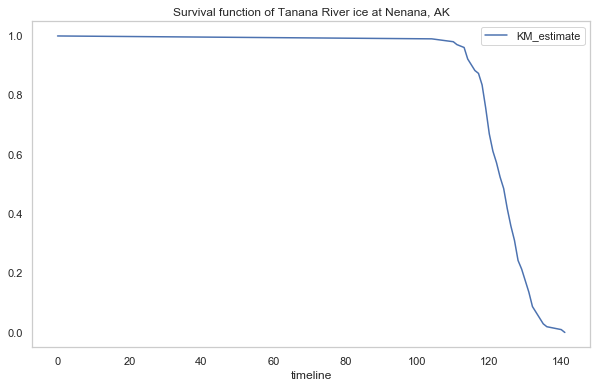

In [163]:
kmf.survival_function_.plot(figsize = (10,6))
plt.title('Survival function of Tanana River ice at Nenana, AK');

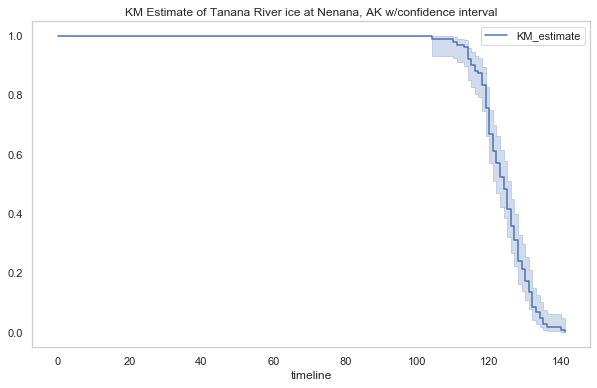

In [162]:
kmf.plot(figsize = (10,6));
plt.title('KM Estimate of Tanana River ice at Nenana, AK w/confidence interval');

In [136]:
kmf.median_survival_time_

124.0

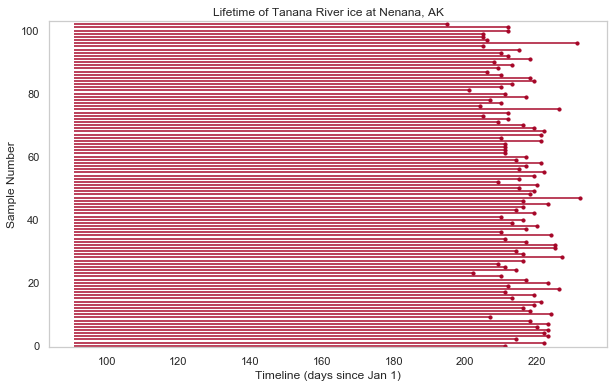

In [178]:
plt.figure(figsize = (10, 6))
plot_lifetimes(durations = df_survival['day_of_year'],
               event_observed = df_survival['observed'],
               entry = df_survival['observation_entry']);
plt.xlabel('Timeline (days since Jan 1)')
plt.ylabel('Sample Number')
plt.title('Lifetime of Tanana River ice at Nenana, AK');

In [98]:
from lifelines import (WeibullFitter, ExponentialFitter,
LogNormalFitter, LogLogisticFitter, NelsonAalenFitter,
PiecewiseExponentialFitter, GeneralizedGammaFitter, SplineFitter)

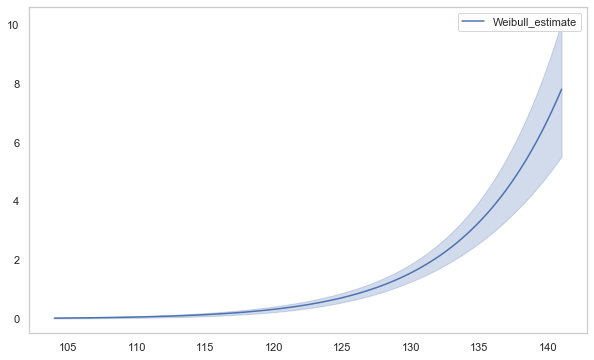

In [153]:
wf = WeibullFitter().fit(T, E)

wf.print_summary()
plt.figure(figsize = (10, 6))
wf.plot();

In [154]:
# create knots for lifelines spline fitter
surv_min = df_survival['day_of_year'].min()
surv_1q = df_survival['day_of_year'].quantile(0.25)
surv_med = df_survival['day_of_year'].median()
surv_3q = df_survival['day_of_year'].quantile(0.75)
surv_max = df_survival['day_of_year'].max()

120.0

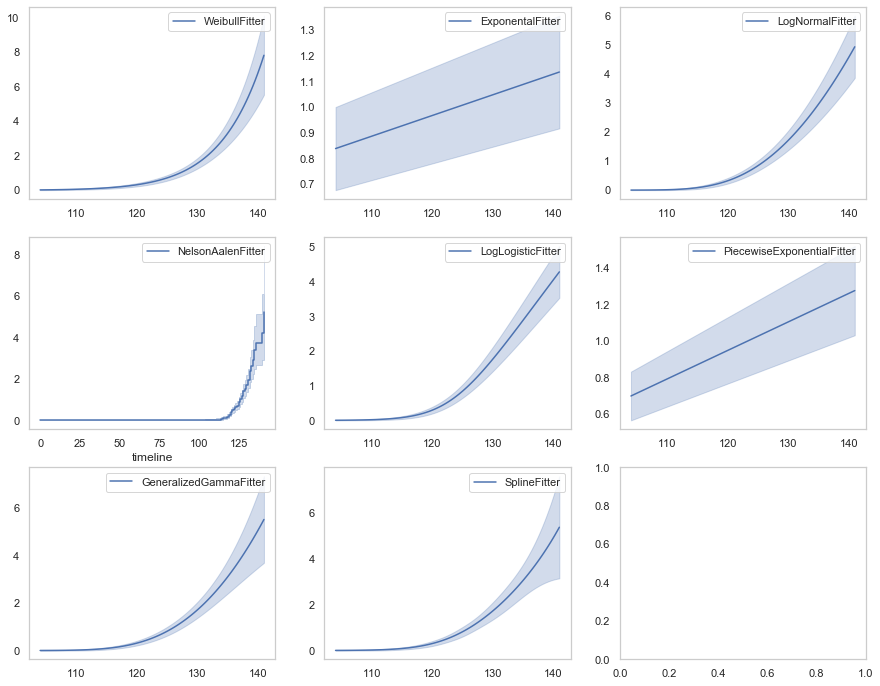

In [158]:
fig, axes = plt.subplots(3, 3, figsize=(15, 12))

wbf = WeibullFitter().fit(T, E, label='WeibullFitter')
exf = ExponentialFitter().fit(T, E, label='ExponentalFitter')
lnf = LogNormalFitter().fit(T, E, label='LogNormalFitter')
naf = NelsonAalenFitter().fit(T, E, label='NelsonAalenFitter')
llf = LogLogisticFitter().fit(T, E, label='LogLogisticFitter')
pwf = PiecewiseExponentialFitter([40, 60]).fit(T, E, label='PiecewiseExponentialFitter')
gg = GeneralizedGammaFitter().fit(T, E, label='GeneralizedGammaFitter')
spf = SplineFitter([surv_min, surv_1q, surv_med, surv_3q, surv_max]).fit(T, E, label='SplineFitter')

wbf.plot_cumulative_hazard(ax=axes[0][0])
exf.plot_cumulative_hazard(ax=axes[0][1])
lnf.plot_cumulative_hazard(ax=axes[0][2])
naf.plot_cumulative_hazard(ax=axes[1][0])
llf.plot_cumulative_hazard(ax=axes[1][1])
pwf.plot_cumulative_hazard(ax=axes[1][2])
gg.plot_cumulative_hazard(ax=axes[2][0])
spf.plot_cumulative_hazard(ax=axes[2][1]);

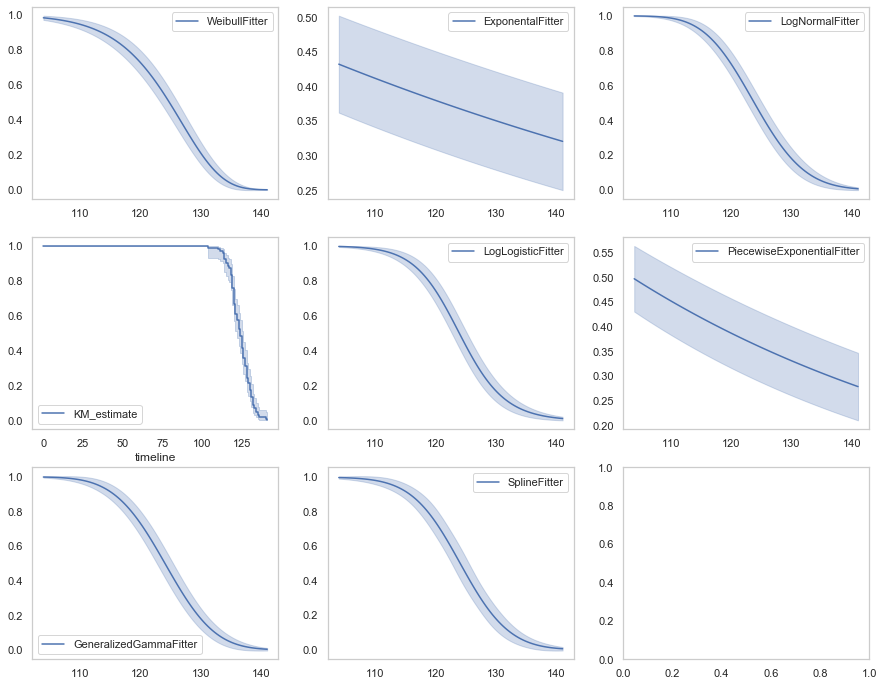

In [161]:
fig, axes = plt.subplots(3, 3, figsize=(15, 12))

wbf.plot_survival_function(ax=axes[0][0])
exf.plot_survival_function(ax=axes[0][1])
lnf.plot_survival_function(ax=axes[0][2])
kmf.plot_survival_function(ax=axes[1][0])
llf.plot_survival_function(ax=axes[1][1])
pwf.plot_survival_function(ax=axes[1][2])
gg.plot_survival_function(ax=axes[2][0])
spf.plot_survival_function(ax=axes[2][1]);

In [206]:
df_survival

,Date,Time,day_of_year,observed,observation_entry
0,1917-04-30,2020-02-23 11:30:00,120,1,91
1,1918-05-11,2020-02-23 09:33:00,131,1,91
2,1919-05-03,2020-02-23 14:33:00,123,1,91
3,1920-05-11,2020-02-23 10:46:00,132,1,91
4,1921-05-11,2020-02-23 06:42:00,131,1,91
...,...,...,...,...,...
98,2015-04-24,2020-02-23 14:25:00,114,1,91
99,2016-04-23,2020-02-23 15:39:00,114,1,91
100,2017-05-01,2020-02-23 12:00:00,121,1,91
101,2018-05-01,2020-02-23 13:18:00,121,1,91


In [207]:
df_past

,Date,moonPhase,precipIntensity,humidity,atmoPressure,windSpeed,windGust,windBearing,cloudCover,uvIndex,...,winningTime,daylightHours,iceThickness,dayOfYear,winningDate,precip_rain,precip_snow,temperatureAvg,numHotDays,numColdDays
0,2009-04-01,0.24,0.0,0.64,1014.8,4.44,24.30,252,0.62,2.0,...,0,0.568056,45.0,91,0,0,0,14.525,0,1
1,2009-04-02,0.27,0.0,0.57,1019.5,2.97,11.84,90,0.39,2.0,...,0,0.572222,45.0,92,0,0,0,6.145,0,2
2,2009-04-03,0.31,0.0,0.51,1015.2,2.58,13.08,324,0.21,3.0,...,0,0.577083,45.0,93,0,0,0,13.065,0,3
3,2009-04-04,0.34,0.0,0.58,1022.7,4.13,16.16,314,0.30,3.0,...,0,0.581944,45.0,94,0,0,0,13.490,0,4
4,2009-04-05,0.38,0.0,0.58,1018.9,2.51,13.69,66,0.00,3.0,...,0,0.586111,45.0,95,0,0,0,12.100,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
483,2016-05-27,0.70,0.0,0.64,1023.0,0.66,4.80,349,0.93,3.0,...,0,0.831250,32.3,148,0,0,0,52.530,4,14
484,2016-05-28,0.74,0.0,0.53,1019.2,2.81,9.89,68,0.22,6.0,...,0,0.835417,32.3,149,0,0,0,54.460,4,14
485,2016-05-29,0.77,0.0,0.31,1018.8,7.04,18.66,61,0.00,6.0,...,0,0.839583,32.3,150,0,0,0,60.820,5,14
486,2016-05-30,0.81,0.0,0.34,1016.8,4.19,10.99,64,0.03,6.0,...,0,0.843750,32.3,151,0,0,0,62.455,6,14


In [208]:
df_past.groupby(df_past['Date'].dt.year)['numHotDays'].max()

Date
2009     9
2010    12
2011    13
2012     8
2013     9
2014     3
2015    18
2016     7
Name: numHotDays, dtype: int64

_TODO_: continue with survival analysis regression
* need to figure out how to combine weather data with survival data for regression
* need to get more weather data? small number of observations when using yearly events means wide confidence interval in survival function